<a href="https://colab.research.google.com/github/CascadiaRunner/Thinkful/blob/master/Challenge_Build_your_own_NLP_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import inaugural, stopwords
from collections import Counter
import nltk
nltk.download('inaugural')

[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

In [0]:
bush = inaugural.raw('2001-Bush.txt')
obama = inaugural.raw('2009-Obama.txt')

In [0]:
def text_cleaner(text):
    text = re.sub(r'\n',' ',text)
#     text = re.sub("[\[].*?[\]]", "", text)
#     text = ' '.join(text.split())
    return text

In [0]:
bush = text_cleaner(bush)
obama = text_cleaner(obama)

In [0]:
nlp = spacy.load('en')
bush_inaug = nlp(bush)
obama_inaug = nlp(obama)

In [98]:
# Group into sentences.
bush_sents = [[sent, "Bush"] for sent in bush_inaug.sents]
obama_sents = [[sent, "Obama"] for sent in obama_inaug.sents]

# Combine the sentences from the two speeches.
sentences = pd.DataFrame(bush_sents + obama_sents)
sentences.columns = ['speech', 'president']
sentences.head()

,speech,president
0,"(President, Clinton, ,, distinguished, guests,...",Bush
1,"(With, a, simple, oath, ,, we, affirm, old, tr...",Bush
2,"(As, I, begin, ,, I, thank, President, Clinton...",Bush
3,"(And, I, thank, Vice, President, Gore, for, a,...",Bush
4,"(I, am, honored, and, humbled, to, stand, here...",Bush


In [0]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(100)]
  
def bow_features(sentences_df, common_words, verbose=False, batch_size=100):
    word_counts = pd.DataFrame(columns=common_words)
    i = 0
    for sentence in sentences_df.iloc[:,0]:
        # repeat this for every sentence
        x = pd.Series(sentence).value_counts()
        x = x[pd.Series([str(x) for x in x.index]).isin(common_words).values]
        word_counts.loc[i,:] = 0
        word_counts.loc[i,[str(x) for x in x.index]] = x.values
        if verbose:
            if i % batch_size == 0:
                print("Processing row {}".format(i))
        i += 1
    return word_counts

In [0]:
bushwords = bag_of_words(bush_inaug)
obamawords = bag_of_words(obama_inaug)

common_words = set(bushwords + obamawords)

In [101]:
word_counts = bow_features(sentences, common_words, verbose=True)

Processing row 0
Processing row 100
Processing row 200


In [0]:
from sklearn.model_selection import train_test_split

# create target variable
# Here 0 indicates that Bush was the author
# and if 1 then Obama is the author
Y = (sentences.president == 'Obama').astype(int).values
X = word_counts.astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.3,
                                                    random_state=0)

In [108]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators' : [50, 100, 200, 300],
         'learning_rate' : [0.01, 0.05, 0.1, 0.20],
         'max_depth' : [5, 10, 15, 20]}

gbc = ensemble.GradientBoostingClassifier()
clf = GridSearchCV(gbc, params, cv=5)

train = clf.fit(X_train, y_train)


print('Training set score:', clf.score(X_train, y_train))
print('Test set score:', clf.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Training set score: 0.9932432432432432
Test set score: 0.640625


In [109]:
nltk.download('punkt')


bush=inaugural.paras('2001-Bush.txt')
obama=inaugural.paras('2009-Obama.txt')
bush_paras=[]
obama_paras=[]
for paragraph in bush:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    bush_paras.append(' '.join(para))
    
for paragraph in obama:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    obama_paras.append(' '.join(para))

print(bush_paras[0:2])
print(obama_paras[0:2])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['President Clinton , distinguished guests and my fellow citizens , the peaceful transfer of authority is rare in history , yet common in our country .', 'As I begin , I thank President Clinton for his service to our nation .']
['My fellow citizens :', 'I stand here today humbled by the task before us , grateful for the trust you have bestowed , mindful of the sacrifices borne by our ancestors .']


In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(bush_paras, test_size=0.3, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=None, #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
bush_inaug_tfidf=vectorizer.fit_transform(bush_paras)
print("Number of features: %d" % bush_inaug_tfidf.get_shape()[1])


Number of features: 56


In [113]:
# Bush Inaugural Address

X_train_tfidf, X_test_tfidf= train_test_split(bush_inaug_tfidf, test_size=0.3, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[2])
print('Tf_idf vector:', tfidf_bypara[2])

Original sentence: But the stakes for America are never small .
Tf_idf vector: {'small': 3.8134107167600364, 'stakes': 3.8134107167600364, 'america': 2.4271163556401456}


In [75]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(10)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 67.46275961215484


In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(10)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

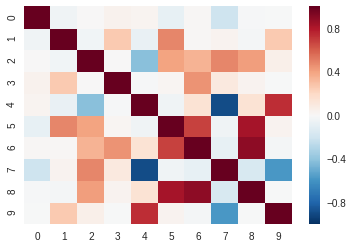

Key:
0 And I thank Vice President Gore for a contest conducted with spirit and ended with grace .
1 Never tiring , never yielding , never finishing , we renew that purpose today , to make our country more just and generous , to affirm the dignity of our lives and every life .
2 But the stakes for America are never small .
3 Today , we affirm a new commitment to live out our nation ' s promise through civility , courage , compassion and character .
4 And whatever our views of its cause , we can agree that children at risk are not at fault .
5 Together , we will reclaim America ' s schools , before ignorance and apathy claim more young lives .
6 America , at its best , matches a commitment to principle with a concern for civility .
7 What you do is as important as anything government does .
8 America , at its best , is also courageous .
9 Americans are generous and strong and decent , not because we believe in ourselves , but because we hold beliefs beyond ourselves .


In [76]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(obama_paras, test_size=0.3, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=None, #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
obama_inaug_tfidf=vectorizer.fit_transform(obama_paras)
print("Number of features: %d" % obama_inaug_tfidf.get_shape()[1])

Number of features: 27


In [118]:
# Obama Inaugural Address

X_train_tfidf, X_test_tfidf= train_test_split(obama_inaug_tfidf, test_size=0.3, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[2])
print('Tf_idf vector:', tfidf_bypara[2])

Original sentence: Our challenges may be new .
Tf_idf vector: {'new': 3.224623551524334, 'challenges': 3.512305623976115}


In [119]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(10)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 86.1705699802513


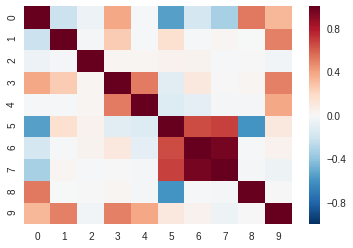

Key:
0 Thank you .
1 " Let it be told to the future world ... that in the depth of winter , when nothing but hope and virtue could survive ... that the city and the country , alarmed at one common danger , came forth to meet ...
2 Our challenges may be new .
3 So let us mark this day with remembrance , of who we are and how far we have traveled .
4 On this day , we come to proclaim an end to the petty grievances and false promises , the recriminations and worn - out dogmas that for far too long have strangled our politics .
5 For us , they fought and died , in places like Concord and Gettysburg ; Normandy and Khe Sahn .
6 These are the indicators of crisis , subject to data and statistics .
7 Now , there are some who question the scale of our ambitions  who suggest that our system cannot tolerate too many big plans .
8 Time and again these men and women struggled and sacrificed and worked till their hands were raw so that we might live a better life .
9 On this day , we gather because 

In [120]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])